# **Predicting Diamond Prices Using Regression Models and Data Transformation Techniques**

## **Abstract:**

This notebook demonstrates the process of training, evaluating, and making predictions with a regression model for predicting diamond prices. The model is built using various machine learning algorithms, with hyperparameter tuning applied to optimize performance. Preprocessing techniques such as feature scaling, label encoding for categorical variables, and PowerTransformer for feature normalization are incorporated. The notebook employs the pipeline concept to streamline the workflow, ensuring a seamless transition from data preprocessing to model training and evaluation. Custom data is first transformed using label encoders and a PowerTransformer. After prediction, the transformed target variable (price) is inverse-transformed to return the predicted price to its original scale. The notebook also includes the process of saving and loading the trained model and transformers for efficient deployment and real-world use.

# **1.** **Title and Overview**

**Title:** Diamonds Dataset Analysis and Predictive Modeling

**Overview:**

This notebook explores the diamonds dataset provided by Seaborn. The goal is to perform exploratory data analysis (EDA) to understand trends and patterns in diamond pricing and build a predictive model to estimate diamond prices based on key features like carat, cut, and clarity.



In [9]:
# Import necessary libraries for data analysis and modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import regression models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# Import evaluation metrics for model performance
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Import preprocessing libraries for feature scaling, missing value imputation, and encoding categorical variables
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Import GridSearchCV for hyperparameter tuning and model selection
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# Import joblib for saving the trained model
import joblib


# **2. Dataset Description**

**Source:** The dataset is loaded from the Seaborn library (sns.load_dataset('diamonds')).

**Dataset Features:**



*   **carat:** Weight of the diamond.
*   **cut:** Quality of the cut (e.g., Fair, Good, Very Good, Premium, Ideal).

*   **color:** Diamond color, from J (worst) to D (best).

*   **clarity:** Measurement of the diamond's clarity (e.g., I1, SI1, VS1).
*   **depth:** Total depth percentage = (z / mean(x, y)) × 100.


*   **table:** Width of the top of the diamond relative to the widest point.

*   **price:** Price in USD.
*   **x, y, z:** Length, width, and depth in mm.









In [10]:
# Load the Diamonds dataset from Seaborn
df = sns.load_dataset('diamonds')

# Sample a subset of 10,000 rows for faster processing (if needed)
diamonds_df = df.sample(10000)

# Display the first few rows of the dataset
print("First five rows of the dataset:")
print(diamonds_df.head())

# Print the shape of the dataset to understand its dimensions
print("Shape of data is: ", diamonds_df.shape)

# Display summary information about the dataset (e.g., non-null counts, data types)
print("--------------------------------------------->")
print("Info of the data is: ")
diamonds_df.info()

# Display the column names of the dataset
print("--------------------------------------------->")
print("Column names are: ", diamonds_df.columns)


First five rows of the dataset:
       carat      cut color clarity  depth  table  price     x     y     z
41514   0.44    Ideal     D     VS1   61.3   56.0   1235  4.87  4.92  3.00
22068   1.50  Premium     D     SI2   59.9   60.0  10090  7.48  7.41  4.46
39661   0.42    Ideal     G     VS2   61.6   56.0   1087  4.83  4.82  2.97
39616   0.35  Premium     E     SI2   61.0   58.0    491  4.52  4.56  2.77
11506   1.01    Ideal     F     SI2   60.4   59.0   5020  6.48  6.51  3.92
Shape of data is:  (10000, 10)
--------------------------------------------->
Info of the data is: 
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 41514 to 29262
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    10000 non-null  float64 
 1   cut      10000 non-null  category
 2   color    10000 non-null  category
 3   clarity  10000 non-null  category
 4   depth    10000 non-null  float64 
 5   table    10000 non-null  float64

# **3. Data Preprocessing**
**Steps:**




1.   **Missing Values:** Check for and handle any missing values (e.g., df.isnull().sum()).
2.   **Outliers:** Identify outliers in numerical features like carat and price using boxplots and decide whether to cap/remove them.
3.  **Encoding Categorical Features:** Encode categorical columns (cut, color, clarity) using techniques like one-hot or label encoding.
4. **Feature Scaling:** Normalize numerical features like carat, depth, and price for improved model performance.







3.1- Check **missing** values ?

In [11]:
# Check for missing values in the dataset and sort them in descending order
print("Missing values in each column:")
missing_values = diamonds_df.isnull().sum().sort_values(ascending=False)
print(missing_values)


Missing values in each column:
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


Checking **unique** values?

In [12]:
# Loop through categorical and object-type columns to print unique values in each
for column in diamonds_df.select_dtypes(include=['category', 'object']).columns:
    print(f"Unique values in '{column}' are: {diamonds_df[column].unique()} \n")

Unique values in 'cut' are: ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']
Categories (5, object): ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair'] 

Unique values in 'color' are: ['D', 'G', 'E', 'F', 'I', 'H', 'J']
Categories (7, object): ['D', 'E', 'F', 'G', 'H', 'I', 'J'] 

Unique values in 'clarity' are: ['VS1', 'SI2', 'VS2', 'SI1', 'VVS2', 'IF', 'VVS1', 'I1']
Categories (8, object): ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1'] 



3.2- Check the **outlier** values ?

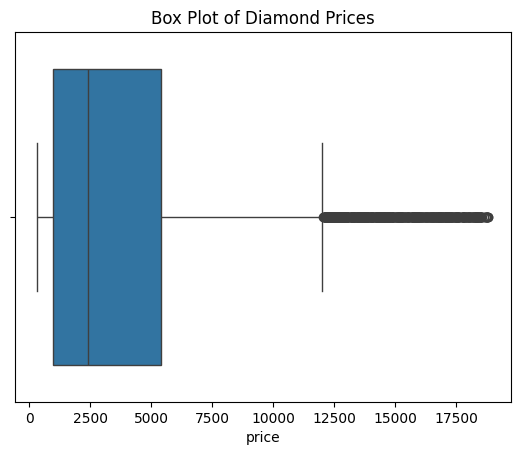

In [13]:
# Create a box plot to visualize the distribution and detect outliers in diamond prices
sns.boxplot(x='price', data=diamonds_df)

# Add a title to the plot
plt.title('Box Plot of Diamond Prices')

# Display the plot
plt.show()


3.3 **Normalize** the data

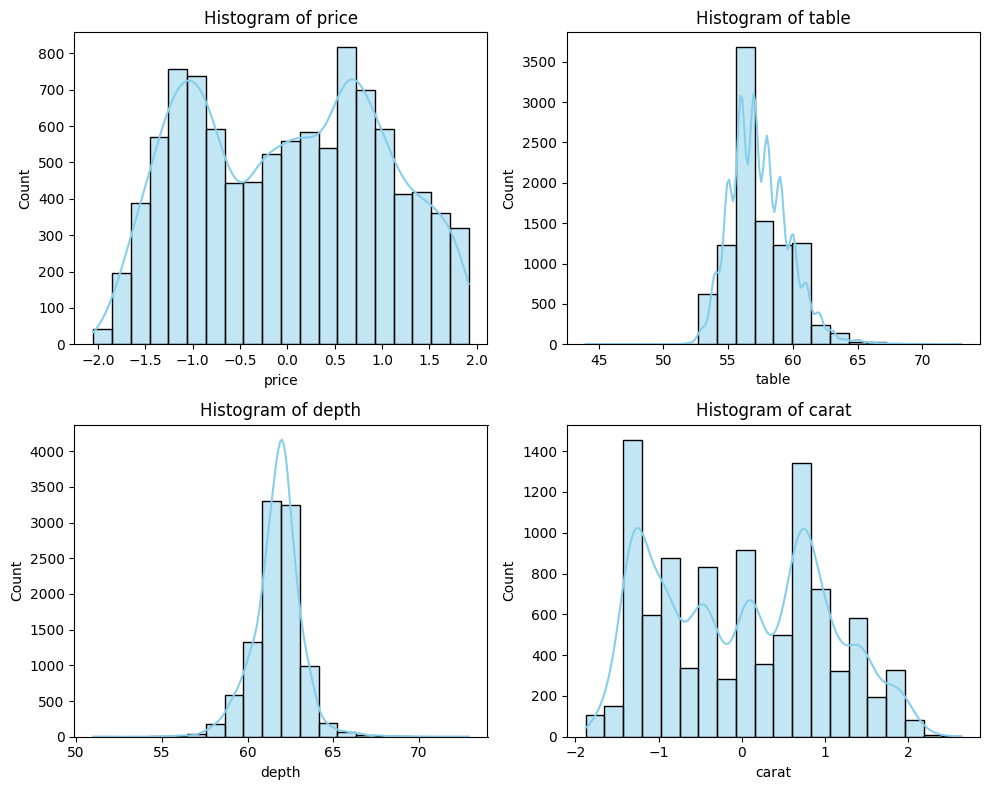

In [14]:
from sklearn.preprocessing import PowerTransformer
import joblib

# Create a copy of the original dataset for transformation
normalized_df = diamonds_df.copy()

# Initialize PowerTransformer for feature and target transformation (Yeo-Johnson method)
pt_features = PowerTransformer(method='yeo-johnson')
pt_target = PowerTransformer(method='yeo-johnson')

# Fit transformers on the specific columns ('carat' as feature, 'price' as target)
pt_features.fit(normalized_df[['carat']])  # Fit transformer on 'carat' feature
pt_target.fit(normalized_df[['price']])    # Fit transformer on 'price' target

# Save the transformers for later use (useful when deploying models)
joblib.dump(pt_features, 'carat_transformer.pkl')
joblib.dump(pt_target, 'price_transformer.pkl')

# Apply the transformations to the 'carat' and 'price' columns
normalized_df['carat'] = pt_features.transform(normalized_df[['carat']])
normalized_df['price'] = pt_target.transform(normalized_df[['price']])

# List of numerical columns for visualization
numerical_columns = ['price', 'table', 'depth', 'carat', 'x', 'y', 'z']

# Set up a 2x2 grid for plotting histograms of selected numerical columns
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

# Loop through numerical columns to create histograms
for i, col in enumerate(numerical_columns):
    if i < len(axes):
        sns.histplot(normalized_df[col], bins=20, color='skyblue', edgecolor='black', kde=True, ax=axes[i])
        axes[i].set_title(f'Histogram of {col}')
    else:
        break  # Stop if there are no more axes available

# Adjust the layout to avoid overlapping subplots
plt.tight_layout()

# Display the plots
plt.show()


In [15]:
# Generate summary statistics for the dataset (after transformation)
summary_stats = normalized_df.describe()

# Print the summary statistics
print(summary_stats)


              carat         depth         table         price             x  \
count  1.000000e+04  10000.000000  10000.000000  1.000000e+04  10000.000000   
mean   2.188472e-16     61.738890     57.447810 -3.083755e-16      5.738073   
std    1.000050e+00      1.423029      2.227644  1.000050e+00      1.126040   
min   -1.877595e+00     51.000000     44.000000 -2.052738e+00      0.000000   
25%   -9.234720e-01     61.000000     56.000000 -9.133144e-01      4.720000   
50%    4.235766e-02     61.800000     57.000000  3.380342e-02      5.700000   
75%    7.745927e-01     62.500000     59.000000  8.001282e-01      6.540000   
max    2.634163e+00     72.900000     73.000000  1.914846e+00     10.140000   

                  y             z  
count  10000.000000  10000.000000  
mean       5.739769      3.542792  
std        1.118038      0.695111  
min        0.000000      0.000000  
25%        4.730000      2.910000  
50%        5.720000      3.530000  
75%        6.540000      4.040000  


3.4 - **Encode** the categorical columns

In [16]:
from sklearn.preprocessing import LabelEncoder
import joblib

# Initialize separate LabelEncoders for each categorical column
cut_encoder = LabelEncoder()
color_encoder = LabelEncoder()
clarity_encoder = LabelEncoder()

# Fit the encoders on their respective columns in the normalized dataset
normalized_df['cut'] = cut_encoder.fit_transform(normalized_df['cut'])
normalized_df['color'] = color_encoder.fit_transform(normalized_df['color'])
normalized_df['clarity'] = clarity_encoder.fit_transform(normalized_df['clarity'])

# Save each encoder for later use (useful when deploying models)
joblib.dump(cut_encoder, 'cut_encoder.pkl')
joblib.dump(color_encoder, 'color_encoder.pkl')
joblib.dump(clarity_encoder, 'clarity_encoder.pkl')

# Later, you can load each encoder separately:
cut_encoder = joblib.load('cut_encoder.pkl')
color_encoder = joblib.load('color_encoder.pkl')
clarity_encoder = joblib.load('clarity_encoder.pkl')

# Display the classes learned by each encoder (the mapping between original labels and encoded values)
print("Classes learned by the cut encoder:", cut_encoder.classes_)
print("Classes learned by the color encoder:", color_encoder.classes_)
print("Classes learned by the clarity encoder:", clarity_encoder.classes_)


Classes learned by the cut encoder: ['Fair' 'Good' 'Ideal' 'Premium' 'Very Good']
Classes learned by the color encoder: ['D' 'E' 'F' 'G' 'H' 'I' 'J']
Classes learned by the clarity encoder: ['I1' 'IF' 'SI1' 'SI2' 'VS1' 'VS2' 'VVS1' 'VVS2']


# **4. Exploratory Data Analysis (EDA)**
**Visualizations and Insights:**

4.1 - **Correlation** **Heatmap:**

Heatmap to explore relationships among numerical features.

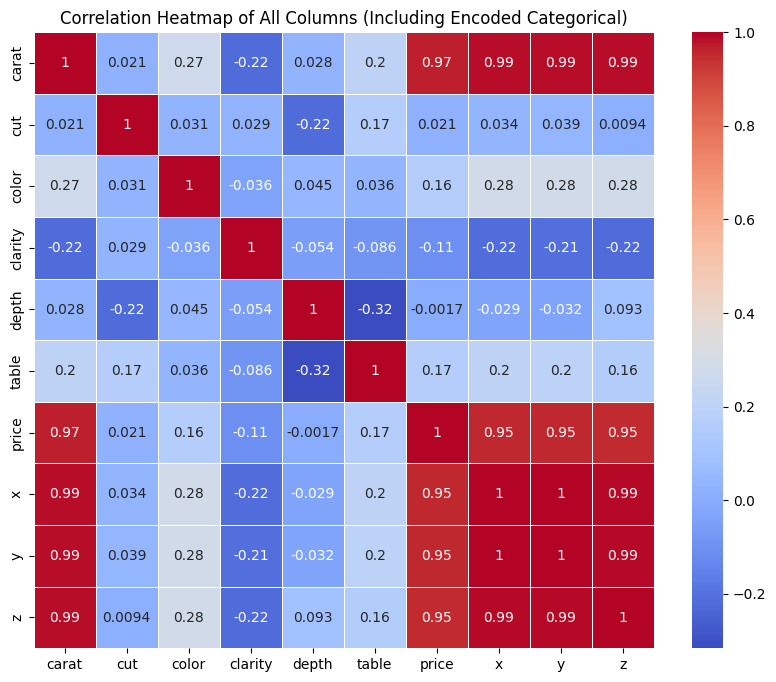

In [17]:
# Set the figure size for the heatmap
plt.figure(figsize=(10, 8))

# Create a heatmap to visualize correlations between all columns in the dataset
sns.heatmap(normalized_df.corr(),
            annot=True,             # Display correlation values on the heatmap
            cmap='coolwarm',        # Use 'coolwarm' colormap for heatmap coloring
            linewidths=0.5)         # Add separation lines between cells

# Add a title to the heatmap for context
plt.title('Correlation Heatmap of All Columns (Including Encoded Categorical)')

# Display the heatmap
plt.show()


4.2 **Relationship Analysis:**

Analyze the relationship between price and carat

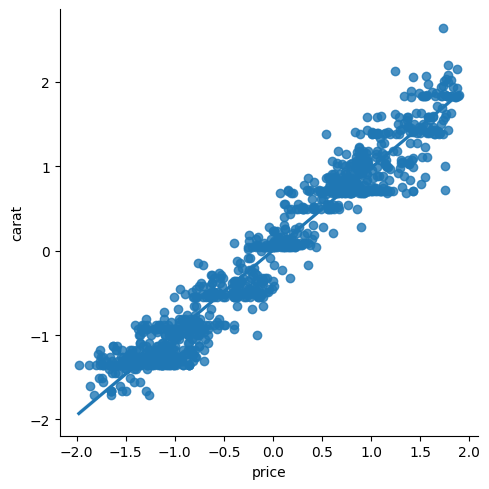

In [18]:
# Create a scatter plot with a linear regression line
sns.lmplot(x='price', y='carat',
           data=normalized_df.sample(frac=0.1, random_state=42))  # Sample 10% of the dataset for visualization

# Display the plot
plt.show()


1.6 - **Pairplot plot**


Pairplot to visualize feature interdependencies.


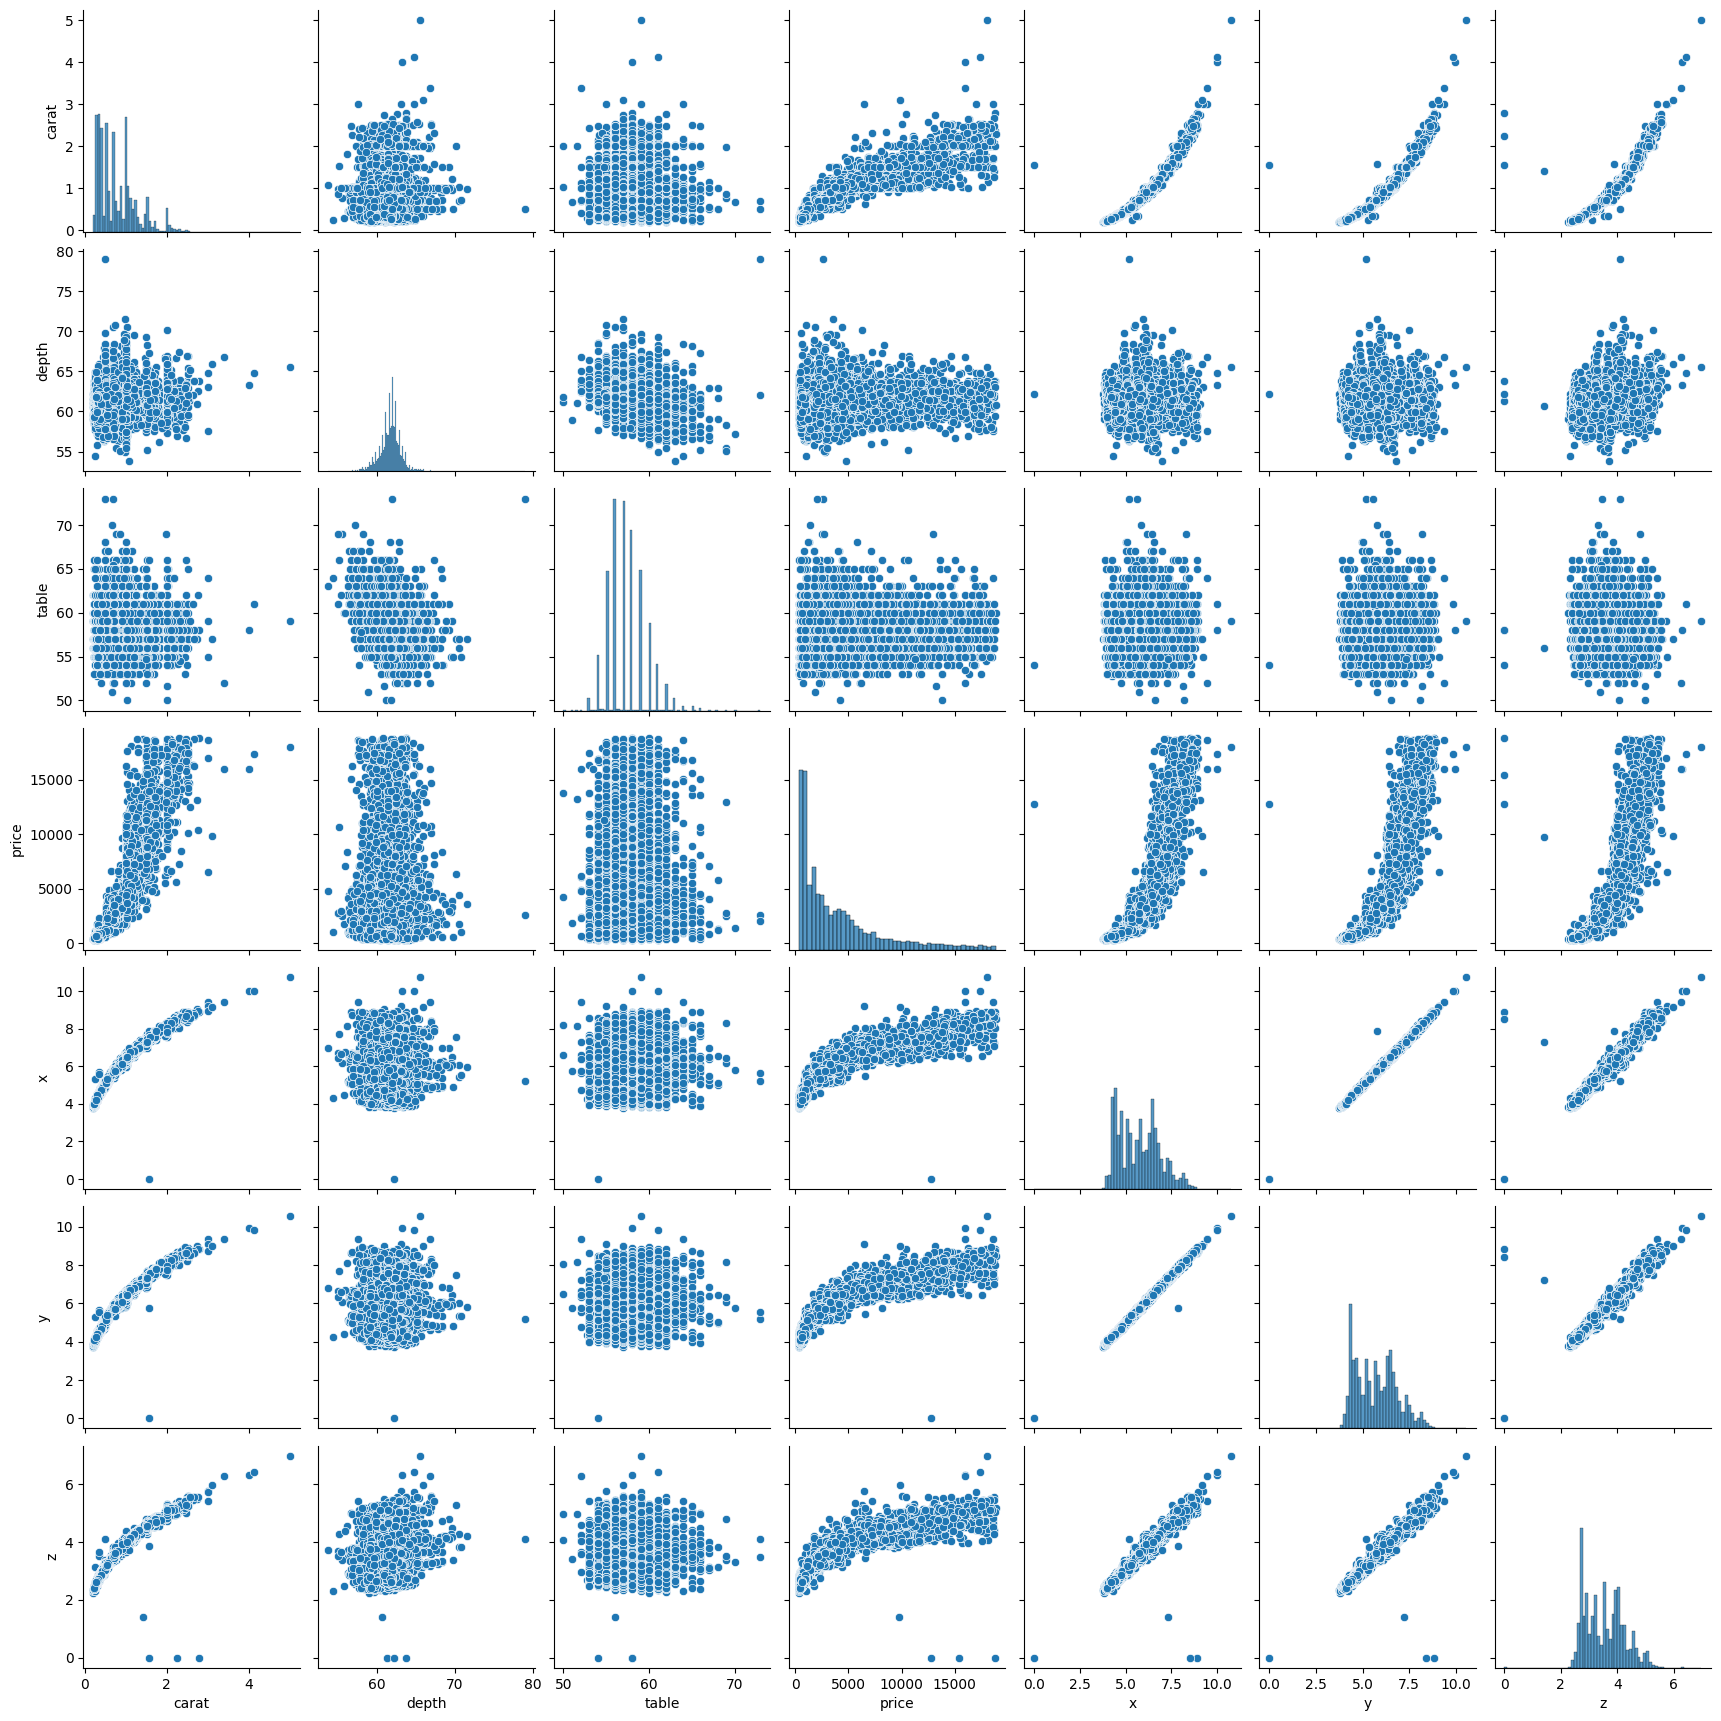

In [8]:
# Create a pairplot for the diamonds dataset
sns.pairplot(diamonds_df)

# Show the plot
plt.show()

# **5. Model Building**
**Steps:**



1.   **Target Variable:** Define price as the target variable.
2.   **Feature Selection:** Use features like carat, cut, color, and clarity for modeling.
3. **Cross Validation Split:** Split the dataset into training and testing sets (e.g., CV=5).
4. **Modeling:** Train multiple models such as Linear Regression, Decision Trees, and Random Forests to predict price.


In [19]:
# Split the data into features (X) and target variable (y)
X = normalized_df.drop('price', axis=1)  # Drop 'price' column from dataset to get the features
y = normalized_df['price']  # 'price' column as the target variable

# Initialize KFold cross-validation with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Split the data into train and test sets using KFold cross-validation
for train_index, test_index in kf.split(X):  # Generate indices for each split
    # Split features and target into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


5.1 - **Hyperparameter Tuning** (commented, because it takes time and you can tune hyperparameter according to your needs)

In [ ]:
# %%time
# import warnings
# warnings.filterwarnings('ignore')


# # fetch the Linear Regression Model

# lgm=LinearRegression()

# param_grid={
#     'fit_intercept':[True,False],
#     'n_jobs':[-1],
#     'positive':[True],
# }

# grid=GridSearchCV(
#     estimator=lgm,
#     param_grid=param_grid,
#     cv=kf,
#     scoring='r2',
#     verbose=1,
#     n_jobs=-1
# )

# grid.fit(X_train,y_train)

# # printing the best parameters
# print(grid.best_params_)


In [ ]:
# %%time
# import warnings
# warnings.filterwarnings('ignore')


# # fetch the Support Vector Machine (Regressor)
# svr=SVR()

# param_grid={
#     'C':[0.1,1,10],
#     'kernel':['linear','rbf'],
#     'gamma':[1,0.1],
#     'epsilon':[0.1,0.01],
#     'shrinking':[True,False],
#     'max_iter':[10,100,1000],
# }

# grid=GridSearchCV(
#                 estimator=svr,
#                 param_grid=param_grid,
#                 cv=kf,
#                 scoring='r2',
#                 verbose=1,
#                 n_jobs=-1)

# grid.fit(X_train,y_train)

# print(grid.best_params_)

In [ ]:
# %%time
# import warnings
# warnings.filterwarnings('ignore')
# # fetch the Decision Tree (Regressor)
# dtr=DecisionTreeRegressor()


# param_grid={
#     'criterion':['absolute_error','squared_error'],
#     'splitter':['best','random'],
#     'max_depth':[None,5,10],
#     'splitter':['best','random'],
#     'max_leaf_nodes':[None,5,10],
#     'min_samples_split':[2,5,10],
#     'min_samples_leaf':[1,2,4],
# }

# grid=GridSearchCV(estimator=dtr,
#                 param_grid=param_grid,
#                 cv=kf,
#                 scoring='r2',
#                 verbose=1,
#                 n_jobs=-1)
# grid.fit(X_train,y_train)

# print(grid.best_params_)


In [ ]:
# %%time
# import warnings
# warnings.filterwarnings('ignore')
# # fetch the Random Forest (Regressor)

# rfr=RandomForestRegressor()


# param_grid={
#     'n_estimators':[50,100],
#     'max_depth':[None,5,10],
#     'criterion':['absolute_error','squared_error'],
#     'bootstrap':[True,False],
#     'max_features':['auto','sqrt','log2'],
# }

# grid=GridSearchCV(
#                 estimator=rfr,
#                 param_grid=param_grid,
#                 cv=kf,
#                 scoring='r2',
#                 verbose=1,
#                 n_jobs=-1)

# grid.fit(X_train,y_train)

# print(grid.best_params_)


In [ ]:
# %%time
# import warnings
# warnings.filterwarnings('ignore')
# # fetch the KNeighbours (Regressor)

# knr=KNeighborsRegressor()

# param_grid={
#     'n_neighbors':[3,5,7,10,15],
#     'weights':['uniform','distance'],
#     'algorithm':['auto','ball_tree','kd_tree','brute'],
#     'p':[1,2],
#     'metric':['minkowski','manhattan','euclidean'],
# }

# grid=GridSearchCV(
#                 estimator=knr,
#                 param_grid=param_grid,
#                 cv=kf,
#                 scoring='r2',
#                 verbose=1,
#                 n_jobs=-1)

# grid.fit(X_train,y_train)

# print(grid.best_params_)


In [ ]:
# %%time
# import warnings
# warnings.filterwarnings('ignore')
# # fetch the GradientBoostingRegressor (Regressor)

# gbr=GradientBoostingRegressor()

# param_grid={
#     'n_estimators':[50,100,200,500],
#     'max_depth':[3,5,10,15],
#     'max_features':['auto','sqrt','log2'],
#     'criterion':['squared_error','absolute_error'],
# }


# grid=GridSearchCV(
#                 estimator=gbr,
#                 param_grid=param_grid,
#                 cv=kf,
#                 scoring='r2',
#                 verbose=1,
#                 n_jobs=-1)

# grid.fit(X_train,y_train)

# print(grid.best_params_)

In [ ]:
# %%time
# import warnings
# warnings.filterwarnings('ignore')
# # fetch the XGbooster (Regressor)

# xgb=XGBRegressor()

# param_grid={
#     'n_estimators':[50,100,200,500],
#     'max_depth':[3, 5, 7, 10],
#     'colsample_bytree':[0.5, 0.7, 1.0],
#     'objective':['reg:squarederror', 'reg:squaredlogerror'],
# }



# grid=GridSearchCV(
#                 estimator=xgb,
#                 param_grid=param_grid,
#                 cv=kf,
#                 scoring='r2',
#                 verbose=1,
#                 n_jobs=-1)

# grid.fit(X_train,y_train)

# print(grid.best_params_)

In [21]:
import warnings
warnings.filterwarnings('ignore')

# Define the categorical features
categorical_features = ['cut', 'color', 'clarity']

# Create numeric transformer with median imputation
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))  # Fill missing numeric values with the median
])

# Create categorical transformer with most frequent imputation
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))  # Fill missing categorical values with the most frequent value
])

# Define a preprocessor that applies transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_columns),  # Apply numeric transformer to numerical columns
        ('cat', categorical_transformer, categorical_features)  # Apply categorical transformer to categorical columns
    ]
)

# Define a dictionary of models to be evaluated
models = {
    'LinearRegression': LinearRegression(fit_intercept=False, n_jobs=-1, positive=True),
    'SupportVectorMachine': SVR(C=10, epsilon=0.1, gamma=0.1, kernel='rbf', max_iter=1000, shrinking=True),
    'DecisionTreeRegressor': DecisionTreeRegressor(criterion='squared_error', max_depth=None, max_leaf_nodes=None,
                                                  min_samples_leaf=2, min_samples_split=10, splitter='best'),
    'RandomForestRegressor': RandomForestRegressor(bootstrap=False, criterion='squared_error', max_depth=None,
                                                  max_features='log2', n_estimators=100),
    'KNeighborsRegressor': KNeighborsRegressor(algorithm='auto', metric='minkowski', n_neighbors=3, p=1, weights='distance'),
    'GradientBoostingRegressor': GradientBoostingRegressor(criterion='squared_error', max_depth=5, max_features='log2', n_estimators=500),
    'XGBRegressor': XGBRegressor(colsample_bytree=0.8, max_depth=6, n_estimators=500, learning_rate=0.05,
                                min_child_weight=3, subsample=0.8, gamma=0.1, alpha=0.1)
}

# Initialize variables to track the best model
best_model = None
best_model_name = ""
best_r2_score = float("-inf")  # Start with a very low R^2 score

# Loop through each model to evaluate its performance
for name, model in models.items():
    # Create a pipeline with preprocessor and model
    pipeline = Pipeline([
        ('model', model)  # Add the current model to the pipeline
    ])

    # Perform cross-validation with R^2 score as the metric
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2', error_score='raise')

    # Calculate the mean and standard deviation of R^2 scores
    mean_score = scores.mean()
    std_score = scores.std()

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Update the best model if the current model has a better mean R^2 score
    if mean_score > best_r2_score:
        best_r2_score = mean_score
        best_model = pipeline
        best_model_name = name

# Print the best model's details
print(f"Best Model: {best_model_name} with Cross-Validation R^2 Score: {best_r2_score:.4f}")

# Save the best model to a file for later use
joblib.dump(best_model, 'regression_model.pkl')


Best Model: GradientBoostingRegressor with Cross-Validation R^2 Score: 0.9903


['regression_model.pkl']

In [23]:
import warnings
warnings.filterwarnings('ignore')


categorical_features=['cut','color','clarity']

numeric_transformer= Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
])

categorical_transformer=Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
])


preprocessor=ColumnTransformer(
    transformers=[
        ('num',numeric_transformer, numerical_columns),
        ('cat',categorical_transformer,categorical_features)
    ]
)


models={
    'LinearRegression':LinearRegression(fit_intercept=False,n_jobs=-1,positive=True),
    'SupportVectorMachine':SVR(C=10,epsilon=0.1,gamma=0.1,kernel='rbf',max_iter=1000,shrinking=True),
    'DecisionTreeRegressor':DecisionTreeRegressor(criterion='squared_error',max_depth=None,max_leaf_nodes=None,min_samples_leaf=2,
                                                  min_samples_split=10,splitter='best'),
    'RandomForestRegressor':RandomForestRegressor(bootstrap=False,criterion='squared_error',max_depth=None,max_features='log2',
                                                  n_estimators=100),
    'KNeighborsRegressor':KNeighborsRegressor(algorithm='auto',metric='minkowski',n_neighbors=3,p=1,weights='distance'),
    'GradientBoostingRegressor':GradientBoostingRegressor(criterion='squared_error',max_depth=5,max_features='log2',n_estimators=500),
    'XGBRegressor':XGBRegressor(colsample_bytree=0.7,max_depth=3,n_estimators=500,objective='reg:squarederror'),
}

best_model = None
best_model_name = ""
best_r2_score = float("-inf")

for name, model in models.items():
  # create a pipeline with preprocessor
  pipeline=Pipeline([('model',model)])


  # Fit the piepline
  pipeline.fit(X_train, y_train)
  # make prediction

  y_pred=pipeline.predict(X_test)

  # print the performing metric
  print(name, 'MSE: ', mean_squared_error(y_test, y_pred))
  print(name, 'R2: ', r2_score(y_test, y_pred))
  print(name, 'MAE: ', mean_absolute_error(y_test, y_pred))
  print('\n')




LinearRegression MSE:  0.06005385251569236
LinearRegression R2:  0.9394426702525563
LinearRegression MAE:  0.1917609507459494


SupportVectorMachine MSE:  0.03615782992783318
SupportVectorMachine R2:  0.963539031416517
SupportVectorMachine MAE:  0.14688929503955


DecisionTreeRegressor MSE:  0.017303392356603033
DecisionTreeRegressor R2:  0.9825515401128612
DecisionTreeRegressor MAE:  0.09707680434037393


RandomForestRegressor MSE:  0.012276334943806205
RandomForestRegressor R2:  0.9876207431806664
RandomForestRegressor MAE:  0.08272837528347592


KNeighborsRegressor MSE:  0.02965199888548031
KNeighborsRegressor R2:  0.9700994058006578
KNeighborsRegressor MAE:  0.12886957035020555


GradientBoostingRegressor MSE:  0.008372721497831082
GradientBoostingRegressor R2:  0.9915570835943426
GradientBoostingRegressor MAE:  0.06777594421192332


XGBRegressor MSE:  0.00860796739703996
XGBRegressor R2:  0.9913198654494051
XGBRegressor MAE:  0.06802458368330705




**Predicting the price** on custom data

In [24]:
import pandas as pd
import joblib

# Load the saved encoder, scaler, and model
# Load the saved encoders for categorical columns (cut, color, clarity)
cut_encoder = joblib.load('cut_encoder.pkl')         # Label encoder for 'cut' feature
color_encoder = joblib.load('color_encoder.pkl')     # Label encoder for 'color' feature
clarity_encoder = joblib.load('clarity_encoder.pkl') # Label encoder for 'clarity' feature

# Load the PowerTransformer for the 'carat' feature (to normalize the values)
pt_features = joblib.load('carat_transformer.pkl')   # PowerTransformer for 'carat' feature

# Example custom data (replace with actual non-zero values)
custom_data = {
    'carat': [0.28],  # Non-zero carat value, adjust as needed
    'cut': ['Ideal'],  # Example cut value
    'color': ['I'],    # Example color value
    'clarity': ['VS1'], # Example clarity value
    'depth': [62.0],   # Non-zero depth value
    'table': [56.0],   # Non-zero table value
    'x': [4.2],        # Non-zero x dimension
    'y': [4.24],       # Non-zero y dimension
    'z': [2.62]        # Non-zero z dimension
}

# Create a DataFrame from the custom data dictionary
custom_df = pd.DataFrame(custom_data)

# Convert categorical columns to 'category' type to ensure encoding can be applied
custom_df['cut'] = custom_df['cut'].astype('category')
custom_df['color'] = custom_df['color'].astype('category')
custom_df['clarity'] = custom_df['clarity'].astype('category')

# Apply the LabelEncoder to transform categorical columns into numerical values
custom_df['cut'] = cut_encoder.transform(custom_df['cut'])         # Apply encoding to 'cut'
custom_df['color'] = color_encoder.transform(custom_df['color'])   # Apply encoding to 'color'
custom_df['clarity'] = clarity_encoder.transform(custom_df['clarity']) # Apply encoding to 'clarity'

# Apply the PowerTransformer to the 'carat' feature to normalize its values
custom_df['carat'] = pt_features.transform(custom_df[['carat']])  # Apply transformation to 'carat'

# Check the transformed custom data
print(custom_df)


      carat  cut  color  clarity  depth  table    x     y     z
0 -1.455475    2      5        4   62.0   56.0  4.2  4.24  2.62


In [25]:
import warnings
import joblib

# Ignore warnings for clean output
warnings.filterwarnings('ignore')

# Step 1: Load the PowerTransformer for the target variable ('price')
pt_target = joblib.load('price_transformer.pkl')  # Load the saved PowerTransformer for 'price'

# Step 2: Load the saved regression model
model = joblib.load('regression_model.pkl')  # Replace with the path to your saved regression model

# Step 3: Apply the regression model for prediction on the custom data (without applying transformation to 'price' yet)
predicted_transformed_price = model.predict(custom_df)  # Predict the price based on the custom data

# Display the predicted transformed price
print("Predicted transformed price => ", predicted_transformed_price)

# Step 4: Inverse transform the predicted price to return it to the original scale
# This step will reverse the transformation applied to the target variable (price) during model training
predicted_price = pt_target.inverse_transform(predicted_transformed_price.reshape(-1, 1))  # Inverse transform the predicted price

# Step 5: Display the final predicted price in the original scale
print("Predicted Price:", predicted_price.flatten()[0])  # Flatten to get a single value and display


Predicted transformed price =>  [-1.67542596]
Predicted Price: 472.03481580680085


# **6. References**



*   Seaborn Documentation: https://seaborn.pydata.org



# **7. Clean and Commented Code**



*   Clean: Remove unused or redundant code.
*   Commented: Included comments like # Encoding categorical variables to guide readers.



# **8. Conclusion**

This approach demonstrates a comprehensive and systematic methodology for predicting diamond prices. By incorporating preprocessing, model selection, hyperparameter tuning, and the pipeline framework, we ensure a robust and efficient machine learning pipeline. The techniques presented in this notebook can be applied to similar regression tasks in various domains. The saved model and transformers provide a practical solution for future predictions and real-world deployment, making it a valuable resource for production environments.

# **9. Contact Information**

If you have any questions or would like to discuss the content of this notebook further, feel free to reach out:

- **GitHub**: [github.com/YourUsername](https://github.com/RaiUsama0)
- **LinkedIn**: [linkedin.com/in/YourProfile](https://linkedin.com/in/rai-usama-58159a195)

Looking forward to connecting!